# Generalised truss solver

In [1]:
# DEPENDENCIES
import copy #Allows us to create copies of objects in memory
import math #Math functionality
import numpy as np #Numpy for working with arrays
import matplotlib.pyplot as plt #Plotting functionality

## Structure Data Entry

In [2]:
#=================================START OF DATA ENTRY================================
#Constants
E = 200*10**9 #(N/m^2)
A = 0.005 #(m^2)
xFac = 50 #Scale factor for plotted displacements

#Nodal coordinates [x, y] (in ascending node order)
nodes = np.array([[0,0],
                  [5,8.66],
                  [15,8.66],
                  [20,0],
                  [10,0],
                  [10,-5]])

#Members [node_i, node_j]
members = np.array([[1,2],
                   [2,3],
                   [3,4],
                   [4,5],
                   [1,5],
                   [2,5],
                   [3,5],
                   [5,6]])

#Supports
restrainedDoF = [7,8,11,12] #The degrees of freedom restrained by supports

#Loading
forceVector = np.array([[0,-200000,0,0,0,0,0,0,0,0,0,0]]).T #Vector of externally applied forces

#=================================END OF DATA ENTRY================================

## Plot structure to confirm before proceeding

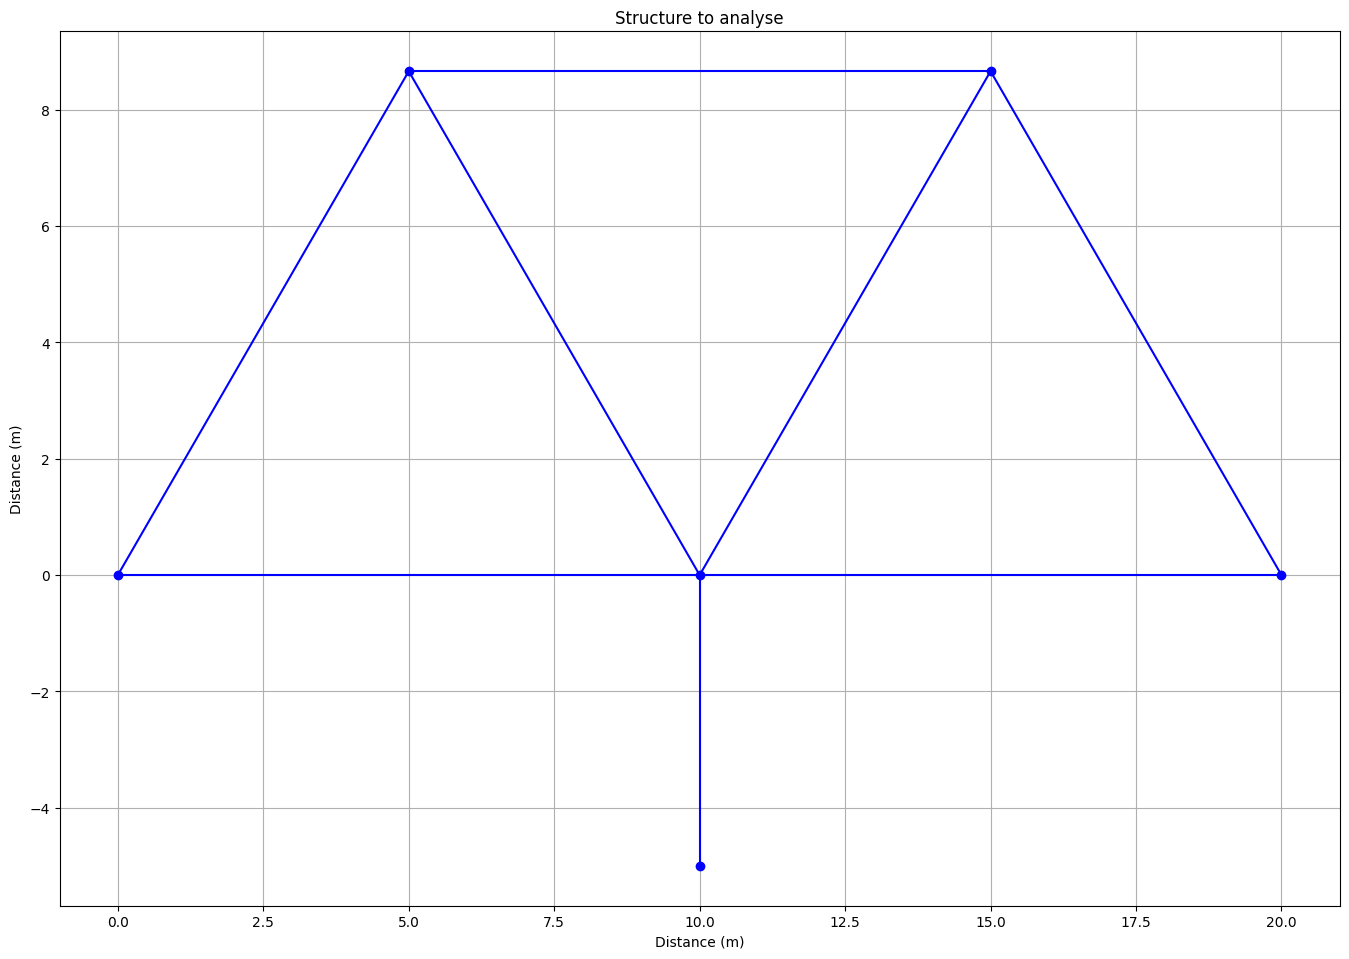

In [3]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for mbr in members:
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member

    #Index of DoF for this member
    ia = 2*node_i-2 #horizontal DoF at node i of this member
    ib = 2*node_i-1 #vertical DoF at node i of this member
    ja = 2*node_j-2 #horizontal DoF at node j of this member
    jb = 2*node_j-1 #vertical DoF at node j of this member

    axes.plot([ix,jx],[iy,jy],'b') #Member

#Plot nodes
for node in nodes:
    axes.plot([node[0]],[node[1]],'bo')

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Structure to analyse')
axes.grid()
plt.show()

## Calculate member orientation and length

In [4]:
#Define a function to calculate member orientation and length
def memberOrientation(memberNo):
    memberIndex = memberNo-1 #Index identifying member in array of members
    node_i = members[memberIndex][0] #Node number for node i of this member
    node_j = members[memberIndex][1] #Node number for node j of this member

    xi = nodes[node_i-1][0] #x-coord for node i
    yi = nodes[node_i-1][1] #y-coord for node i
    xj = nodes[node_j-1][0] #x-coord for node j
    yj = nodes[node_j-1][1] #y-coord for node j

    #Angle of member with respect to horizontal axis

    dx = xj-xi #x-component of vector along member
    dy = yj-yi #y-component of vector along member
    mag = math.sqrt(dx**2 + dy**2) #Magnitude of vector (length of member)
    memberVector = np.array([dx,dy])#Member represented as a vector

    #Need to capture quadrant first then appropriate reference axis and offset angle
    if(dx>0 and dy==0):
        theta = 0
    elif(dx==0 and dy>0):
        theta = math.pi/2
    elif(dx<0 and dy==0):
        theta = math.pi
    elif(dx==0 and dy<0):
        theta = 3*math.pi/2
    elif(dx>0 and dy>0):
        # 0<theta<90
        refVector = np.array([1,0]) # Vector describing the positive x-axis
        theta = math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors
    elif(dx<0 and dy>0):
        # 90<theta<180
        refVector = np.array([0,1]) # Vector describing the positive y-axis
        theta = (math.pi/2) + math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors
    elif(dx<0 and dy<0):
        # 180<theta<270
        refVector = np.array([-1,0]) # Vector describing the negative x-axis
        theta = math.pi + math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors
    else:
        # 270<theta<360
        refVector = np.array([0,-1]) # Vector describing the negative y-axis
        theta = (3*math.pi/2) + math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors

    return [theta, mag]

In [5]:
#Calculate orientation and length for each member and store
orientations = np.array([])#Initialise an array to hold orientations
lengths = np.array([]) #Initialise an array to hold lengths
for n, mbr in enumerate(members):
    [angle, length] = memberOrientation(n+1)
    orientations = np.append(orientations,angle)
    lengths = np.append(lengths,length)

## Define a function to calculate member global stiffness matrix

In [6]:
#Define a function to calculate the global stiffness matrix of an axially loaded bar
def calculateKg(memberNo):
    """
    Calculate the global stiffness matrix for an axially loaded bar
    memberNo: The member number
    """
    theta = orientations[memberNo-1]
    mag = lengths[memberNo-1]

    c = math.cos(theta)
    s = math.sin(theta)

    K11 = (E*A/mag)*np.array([[c**2,c*s],[c*s,s**2]]) #Top left quadrant of global stiffness matrix
    K12 = (E*A/mag)*np.array([[-c**2,-c*s],[-c*s,-s**2]]) #Top right quadrant of global stiffness matrix
    K21 = (E*A/mag)*np.array([[-c**2,-c*s],[-c*s,-s**2]]) #Bottom left quadrant of global stiffness matrix
    K22 = (E*A/mag)*np.array([[c**2,c*s],[c*s,s**2]]) #Bottom right quadrant of global stiffness matrix

    return [K11, K12, K21,K22]

## Build the primary stiffness matrix, Kp

In [7]:
nDoF = np.amax(members)*2 #Total number of degrees of freedom in the problem
Kp = np.zeros([nDoF,nDoF]) #Initialise the primary stiffness matrix

for n, mbr in enumerate(members):
#note that enumerate adds a counter to an iterable (n)

    #Calculate the quadrants of the global stiffness matrix for the member
    [K11, K12, K21,K22] = calculateKg(n+1)

    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    #Primary stiffness matrix indices associated with each node
    #i.e. node 1 occupies indices 0 and 1 (accessed in Python with [0:2])
    ia = 2*node_i-2 #index 0
    ib = 2*node_i-1 #index 1
    ja = 2*node_j-2 #index 2
    jb = 2*node_j-1 #index 3
    Kp[ia:ib+1,ia:ib+1] = Kp[ia:ib+1,ia:ib+1] + K11
    Kp[ia:ib+1,ja:jb+1] = Kp[ia:ib+1,ja:jb+1] + K12
    Kp[ja:jb+1,ia:ib+1] = Kp[ja:jb+1,ia:ib+1] + K21
    Kp[ja:jb+1,ja:jb+1] = Kp[ja:jb+1,ja:jb+1] + K22

## Extract structure stiffness matrix, Ks

In [8]:
restrainedIndex = [x - 1 for x in restrainedDoF] #Index for each restrained DoF (list comprehension)

#Reduce to structure stiffness matrix by deleting rows and columns for restrained DoF
Ks = np.delete(Kp,restrainedIndex,0) #Delete rows
Ks = np.delete(Ks,restrainedIndex,1) #Delete columns
Ks = np.matrix(Ks) # Convert Ks from numpy.ndarray to numpy.matrix to use build in inverter function

## Solve for displacements

In [9]:
forceVectorRed = copy.copy(forceVector)# Make a copy of forceVector so the copy can be edited, leaving the original unchanged
forceVectorRed = np.delete(forceVectorRed,restrainedIndex,0) #Delete rows corresponding to restrained DoF
U = Ks.I*forceVectorRed

## Solve for reactions

In [10]:
#Construct the global displacement vector
UG = np.zeros(nDoF) #Initialise an array to hold the global displacement vector
c=0 #Initialise a counter to track how many restraints have been imposed
for i in np.arange(nDoF):
    if i in restrainedIndex:
        #Impose zero displacement
        UG[i] = 0
    else:
        #Assign actual displacement
        UG[i] = U[c]
        c=c+1

UG = np.array([UG]).T
FG = np.matmul(Kp,UG)

## Solve for member forces

In [11]:
mbrForces = np.array([]) #Initialise an array to hold member forces
for n, mbr in enumerate(members):
    theta = orientations[n]
    mag = lengths[n]

    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member
    #Primary stiffness matrix indices associated with each node
    ia = 2*node_i-2
    ib = 2*node_i-1
    ja = 2*node_j-2
    jb = 2*node_j-1

    #Transformation matrix
    c = math.cos(theta)
    s = math.sin(theta)
    T = np.array([[c,s,0,0],[0,0,c,s]])

    disp = np.array([[UG[ia],UG[ib],UG[ja],UG[jb]]]).T #Global displacements
    disp_local = np.matmul(T,disp)[0] #Local displacements
    F_axial = (A*E/mag)*(disp_local[1]-disp_local[0]) #Axial loads
    mbrForces = np.append(mbrForces,F_axial) #Store axial loads

## Plotting

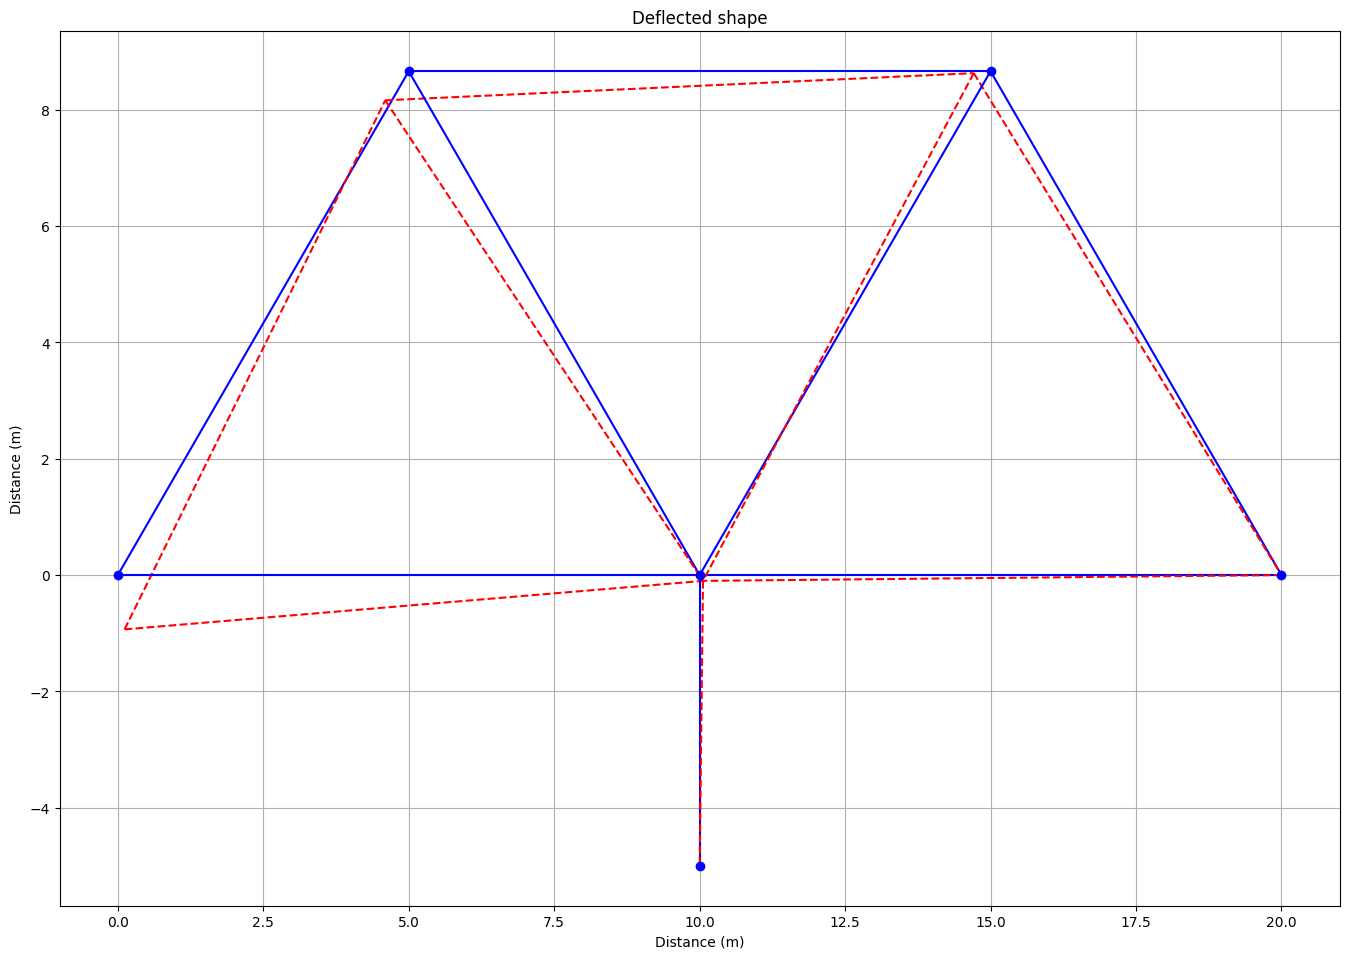

In [12]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for mbr in members:
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member

    #Index of DoF for this member
    ia = 2*node_i-2 #horizontal DoF at node i of this member
    ib = 2*node_i-1 #vertical DoF at node i of this member
    ja = 2*node_j-2 #horizontal DoF at node j of this member
    jb = 2*node_j-1 #vertical DoF at node j of this member

    axes.plot([ix,jx],[iy,jy],'b') #Member
    axes.plot([ix + UG[ia,0]*xFac, jx + UG[ja,0]*xFac], [iy + UG[ib,0]*xFac, jy + UG[jb,0]*xFac],'--r') #Deformed member

#Plot nodes
for node in nodes:
    axes.plot([node[0]],[node[1]],'bo')

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Deflected shape')
axes.grid()
plt.show()

## Summary output

In [13]:
#Generate output statements
print("REACTIONS")
for i in np.arange(0,len(restrainedIndex)):
    index = restrainedIndex[i]
    print("Reaction at DoF {one}: {two} kN".format(one = index+1, two = round(FG[index].item()/1000,2)))

print("")
print("MEMBER FORCES")
for n, mbr in enumerate(members):
    print("Force in member {one} (nodes {two} to {three}) is {four} kN".format(one = n+1, two=mbr[0], three=mbr[1], four=round(mbrForces[n]/1000,2)))

print("")
print("NODAL DISPLACEMENTS")
for n, node in enumerate(nodes):
    ix = 2*(n+1)-2 #horizontal DoF for this node
    iy = 2*(n+1)-1 #vertical DoF for this node

    ux = round(UG[ix,0],5) #Horizontal nodal displacement
    uy = round(UG[iy,0],5) #Vertical nodal displacement
    print("Node {one}: Ux = {two} m, Uy = {three} m".format(one=n+1, two=ux, three=uy))

REACTIONS
Reaction at DoF 7: 0.0 kN
Reaction at DoF 8: -200.0 kN
Reaction at DoF 11: 0.0 kN
Reaction at DoF 12: 400.0 kN

MEMBER FORCES
Force in member 1 (nodes 1 to 2) is 230.94 kN
Force in member 2 (nodes 2 to 3) is 230.95 kN
Force in member 3 (nodes 3 to 4) is 230.94 kN
Force in member 4 (nodes 4 to 5) is -115.47 kN
Force in member 5 (nodes 1 to 5) is -115.47 kN
Force in member 6 (nodes 2 to 5) is -230.94 kN
Force in member 7 (nodes 3 to 5) is -230.94 kN
Force in member 8 (nodes 5 to 6) is -400.0 kN

NODAL DISPLACEMENTS
Node 1: Ux = 0.00231 m, Uy = -0.01867 m
Node 2: Ux = -0.00808 m, Uy = -0.01 m
Node 3: Ux = -0.00577 m, Uy = -0.00067 m
Node 4: Ux = 0.0 m, Uy = 0.0 m
Node 5: Ux = 0.00115 m, Uy = -0.002 m
Node 6: Ux = 0.0 m, Uy = 0.0 m
